# LLM Hallucination Detection via Semantic Entropy & Embedding Geometry
### Multi-Subject Comparative Analysis

**Based on:** Farquhar et al. (2024) · Ricco et al. (2025) · Lee et al. (2018)  
**Dataset:** [MMLU](https://huggingface.co/datasets/cais/mmlu)  
**Runtime:** Google Colab (free tier, T4 GPU recommended)


---

## Features Extracted

| # | Feature | What it measures |
|---|---------|------------------|
| 1 | `H_sem` | Semantic entropy — diversity of meanings |
| 2 | `D_cos` | Centroid cosine dispersion |
| 3 | `M_bar` | Mean Mahalanobis distance from "correct" region |
| 4 | `K`     | Number of semantic clusters |
| 5 | `sig2_S` | Variance of pairwise cosine similarities |

## Install Dependencies

In [1]:
# !pip install -q datasets transformers sentence-transformers \
#              scikit-learn xgboost scipy shap \
#              matplotlib seaborn accelerate

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from datasets import load_dataset
from transformers import T5ForConditionalGeneration, T5Tokenizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import ks_2samp
import xgboost as xgb
import shap
import torch

print(f"PyTorch device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
print("All imports successful")

PyTorch device: cpu
All imports successful


## Configuration

> **Tip:** Add or remove subjects from `mmlu_subjects` to compare across domains.  
> Increase `n_questions` to 200+ for better statistics (takes longer to run).

In [3]:
CONFIG = {
    "dataset_name"   : "cais/mmlu",
    # --- Add / remove subjects here -------------------------------------------
    "mmlu_subjects"  : [
        'abstract_algebra',
        'anatomy',
        'high_school_computer_science',
        'high_school_us_history',
        'professional_law',
    ],
    # --------------------------------------------------------------------------
    "n_questions"    : 60,       # questions per subject (increase to 200 for better stats)
    "n_samples"      : 20,       # responses per question
    "temperature"    : 0.5,
    "sim_threshold"  : 0.85,
    "generator_model": "google/flan-t5-base",
    "embedding_model": "all-MiniLM-L6-v2",
    "random_seed"    : 42,
}

np.random.seed(CONFIG["random_seed"])
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"
ANSWER_MAP    = {0: "A", 1: "B", 2: "C", 3: "D"}
FEATURE_NAMES = ["H_sem", "D_cos", "M_bar", "K", "sig2_S"]
N_SUBJECTS    = len(CONFIG["mmlu_subjects"])

SUBJECT_LABELS = {
    s: s.replace("high_school_", "").replace("_", " ").title()
    for s in CONFIG["mmlu_subjects"]
}

print(f"Running on : {DEVICE}")
print(f"Subjects   : {list(SUBJECT_LABELS.values())}")
print(f"Questions  : {CONFIG['n_questions']} per subject  ({CONFIG['n_questions']*N_SUBJECTS} total)")
print(f"Samples/Q  : {CONFIG['n_samples']}")

Running on : cpu
Subjects   : ['Abstract Algebra', 'Anatomy', 'Computer Science', 'Us History', 'Professional Law']
Questions  : 60 per subject  (300 total)
Samples/Q  : 20


## Load Models

In [4]:
print(f"Loading generator  : {CONFIG['generator_model']} ...")
tokenizer = T5Tokenizer.from_pretrained(CONFIG["generator_model"])
generator = T5ForConditionalGeneration.from_pretrained(CONFIG["generator_model"]).to(DEVICE)
generator.eval()

print(f"Loading embedder   : {CONFIG['embedding_model']} ...")
embedder = SentenceTransformer(CONFIG["embedding_model"])

print("Models ready.")

Loading generator  : google/flan-t5-base ...


Loading weights:   0%|          | 0/282 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Loading embedder   : all-MiniLM-L6-v2 ...


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Models ready.


## Helper Functions

In [5]:
# --- Prompt & generation ---------------------------------------------------

def build_prompt(item):
    choices = item["choices"]
    return (
        "Answer the following multiple choice question. "
        "Respond with only the letter A, B, C, or D.\n\n"
        f"Question: {item['question']}\n"
        f"A) {choices[0]}\nB) {choices[1]}\nC) {choices[2]}\nD) {choices[3]}\nAnswer:"
    )

def sample_responses(item, n_samples, temperature):
    prompt = build_prompt(item)
    inputs = tokenizer(prompt, return_tensors="pt",
                       truncation=True, max_length=512).to(DEVICE)
    with torch.no_grad():
        outputs = generator.generate(
            **inputs,
            max_new_tokens=10,
            do_sample=True,
            temperature=temperature,
            top_p=0.95,
            num_return_sequences=n_samples,
        )
    return [tokenizer.decode(o, skip_special_tokens=True).strip() for o in outputs]

# --- Labelling ----------------------------------------------------------------

def extract_answer_letter(text):
    for ch in text.upper().strip():
        if ch in ("A", "B", "C", "D"):
            return ch
    return None

def label_responses(item, responses):
    correct   = ANSWER_MAP[item["answer"]]
    labels    = [0 if extract_answer_letter(r) == correct else 1 for r in responses]
    hall_rate = np.mean(labels)
    return labels, hall_rate, int(hall_rate > 0.5)

# --- Features -----------------------------------------------------------------

def semantic_entropy(embs, threshold=CONFIG["sim_threshold"]):
    N = len(embs)
    dist_matrix = np.clip(1 - cosine_similarity(embs), 0, None)
    np.fill_diagonal(dist_matrix, 0)
    clustering = AgglomerativeClustering(
        n_clusters=None, metric="precomputed",
        linkage="average", distance_threshold=1 - threshold
    )
    ids = clustering.fit_predict(dist_matrix)
    _, counts = np.unique(ids, return_counts=True)
    probs = counts / N
    H = -np.sum(probs * np.log2(probs + 1e-12))
    return H, len(counts)

def cosine_dispersion(embs):
    centroid = embs.mean(axis=0, keepdims=True)
    return np.mean(1 - cosine_similarity(embs, centroid).flatten())

def mahalanobis_distance(embs, mu, cov_inv):
    diffs = embs - mu
    return np.mean(np.sqrt(np.einsum("ni,ij,nj->n", diffs, cov_inv, diffs)))

def similarity_variance(embs):
    sim   = cosine_similarity(embs)
    upper = sim[np.triu_indices(len(embs), k=1)]
    return np.var(upper)

def extract_features(all_embeddings, response_labels_list):
    correct_embs = np.array([
        emb
        for embs, labels in zip(all_embeddings, response_labels_list)
        for emb, lbl   in zip(embs, labels)
        if lbl == 0
    ])
    if len(correct_embs) < 5:
        correct_embs = np.vstack(all_embeddings)
    mu_ref  = correct_embs.mean(axis=0)
    cov_ref = np.cov(correct_embs.T) + np.eye(correct_embs.shape[1]) * 1e-6
    cov_inv = np.linalg.pinv(cov_ref)

    features = []
    for embs in all_embeddings:
        H, K  = semantic_entropy(embs)
        D     = cosine_dispersion(embs)
        M     = mahalanobis_distance(embs, mu_ref, cov_inv)
        sig2  = similarity_variance(embs)
        features.append([H, D, M, K, sig2])
    return np.array(features)

print("Helper functions defined.")

Helper functions defined.


## Stage 1-3: Data Collection & Feature Extraction (All Subjects)

This cell loops over every subject, samples responses, labels them, embeds them,  
and extracts the 5-feature vector per question.  
Results are stored in `subject_data` — a dict keyed by subject name.

In [ ]:
subject_data = {}   # subject -> {X, y, hall_rates, df}

for subj in CONFIG["mmlu_subjects"]:
    label = SUBJECT_LABELS[subj]
    print(f"\n{'='*60}")
    print(f"  Subject: {label}")
    print(f"{'='*60}")

    # Load dataset (num_proc=1 fixes the RLock / multiprocessing error)
    dataset = load_dataset(
        CONFIG["dataset_name"], subj,
        split="test",
        num_proc=1,
    )
    n   = min(CONFIG["n_questions"], len(dataset))
    rng = np.random.default_rng(CONFIG["random_seed"])
    indices   = rng.choice(len(dataset), n, replace=False)
    questions = [dataset[int(i)] for i in indices]
    print(f"  Loaded {n} questions")

    # Sample model responses
    print(f"  Sampling {CONFIG['n_samples']} responses x {n} questions ...")
    all_responses = []
    for idx, item in enumerate(questions):
        responses = sample_responses(item, CONFIG["n_samples"], CONFIG["temperature"])
        all_responses.append(responses)
        if (idx + 1) % 20 == 0:
            print(f"    [{idx+1}/{n}] done")

    # Label responses
    response_labels_list, hallucination_rates, question_labels = [], [], []
    for item, responses in zip(questions, all_responses):
        lbs, hr, ql = label_responses(item, responses)
        response_labels_list.append(lbs)
        hallucination_rates.append(hr)
        question_labels.append(ql)
    y = np.array(question_labels)
    print(f"  Correct: {(y==0).sum()}  Hallucinated: {(y==1).sum()}  "
          f"Rate: {y.mean()*100:.1f}%")

    # Embed & extract features
    print("  Embedding responses ...")
    all_embeddings = [
        embedder.encode(resp, normalize_embeddings=True, show_progress_bar=False)
        for resp in all_responses
    ]
    print("  Extracting features ...")
    X = extract_features(all_embeddings, response_labels_list)

    df_subj = pd.DataFrame(X, columns=FEATURE_NAMES)
    df_subj["label"]     = y
    df_subj["subject"]   = label
    df_subj["hall_rate"] = hallucination_rates

    subject_data[subj] = {
        "label"     : label,
        "X"         : X,
        "y"         : y,
        "hall_rates": np.array(hallucination_rates),
        "df"        : df_subj,
    }
    print(f"  Feature matrix: {X.shape}")

# Combined dataframe
df_all = pd.concat(
    [subject_data[s]["df"] for s in CONFIG["mmlu_subjects"]],
    ignore_index=True
)

print(f"\nTotal rows in combined dataframe: {len(df_all)}")
print(df_all.groupby("subject")[["label","hall_rate"]].agg(
    hall_count=("label","sum"),
    total=("label","count"),
    mean_hall_rate=("hall_rate","mean")
).round(3))


  Subject: Abstract Algebra
  Loaded 60 questions
  Sampling 20 responses x 60 questions ...
    [20/60] done
    [40/60] done
    [60/60] done
  Correct: 5  Hallucinated: 55  Rate: 91.7%
  Embedding responses ...
  Extracting features ...
  Feature matrix: (60, 5)

  Subject: Anatomy
  Loaded 60 questions
  Sampling 20 responses x 60 questions ...
    [20/60] done


### Hallucination Rate (per question)

For questions with $N$ sampled responses $\{r_1, \dots, r_N\}$ and correct answer $a^*$:

$$\hat{h}_q = \frac{1}{N} \sum_{i=1}^{N} \mathbf{1} \left[ \text{letter}(r_i) \neq a^* \right]$$

Question-level binary label:

$$y_q = \mathbf{1} \left[ \hat{h}_q > 0.5 \right]$$

Mean hallucination rate per subject (over $Q$ questions):

$$\bar{h} = \frac{1}{Q} \sum_{q=1}^{Q} \hat{h}_q, \quad \sigma_h = \sqrt{\frac{1}{Q-1} \sum_{q=1}^{Q} (\hat{h}_q - \bar{h})^2}$$

## Exploratory Analysis
### Hallucination Rates by Subject

,subject,n_questions,n_hallucinated,hall_rate_mean,hall_rate_std,pct_hallucinated
0,Abstract Algebra,60,52,0.725833,0.192550,86.7
1,Computer Science,60,41,0.687500,0.305823,68.3
2,Anatomy,60,42,0.659167,0.380175,70.0
3,Professional Law,60,39,0.640000,0.331509,65.0
4,Us History,60,30,0.522500,0.389635,50.0


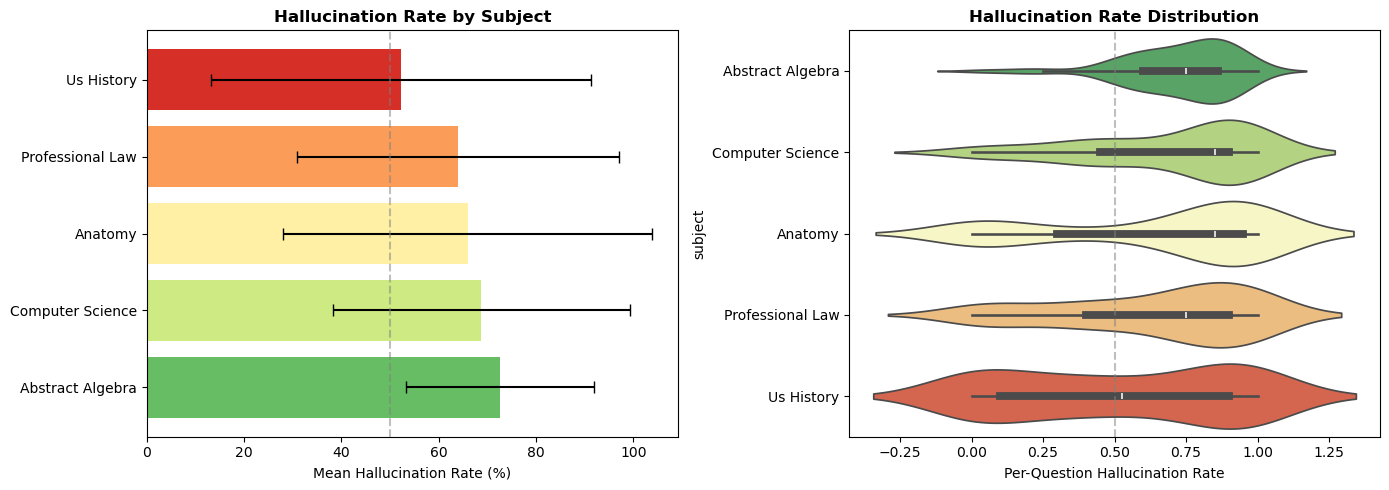

In [ ]:
summary = (
    df_all.groupby("subject")
    .agg(
        n_questions    = ("label", "count"),
        n_hallucinated = ("label", "sum"),
        hall_rate_mean = ("hall_rate", "mean"),
        hall_rate_std  = ("hall_rate", "std"),
    )
    .sort_values("hall_rate_mean", ascending=False)
    .reset_index()
)
summary["pct_hallucinated"] = (
    summary["n_hallucinated"] / summary["n_questions"] * 100
).round(1)

display(summary)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.9, len(summary)))
axes[0].barh(
    summary["subject"], summary["hall_rate_mean"] * 100,
    xerr=summary["hall_rate_std"] * 100,
    color=colors, capsize=4
)
axes[0].set_xlabel("Mean Hallucination Rate (%)")
axes[0].set_title("Hallucination Rate by Subject", fontweight="bold")
axes[0].axvline(50, color="gray", linestyle="--", alpha=0.5)

order = summary["subject"].tolist()
sns.violinplot(
    data=df_all[["subject","hall_rate"]], y="subject", x="hall_rate",
    order=order, orient="h", palette="RdYlGn_r", ax=axes[1], inner="box"
)
axes[1].set_xlabel("Per-Question Hallucination Rate")
axes[1].set_title("Hallucination Rate Distribution", fontweight="bold")
axes[1].axvline(0.5, color="gray", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

### Feature Distributions Across Subjects

One row per feature, one column per subject. Blue = correct, red = hallucinated.

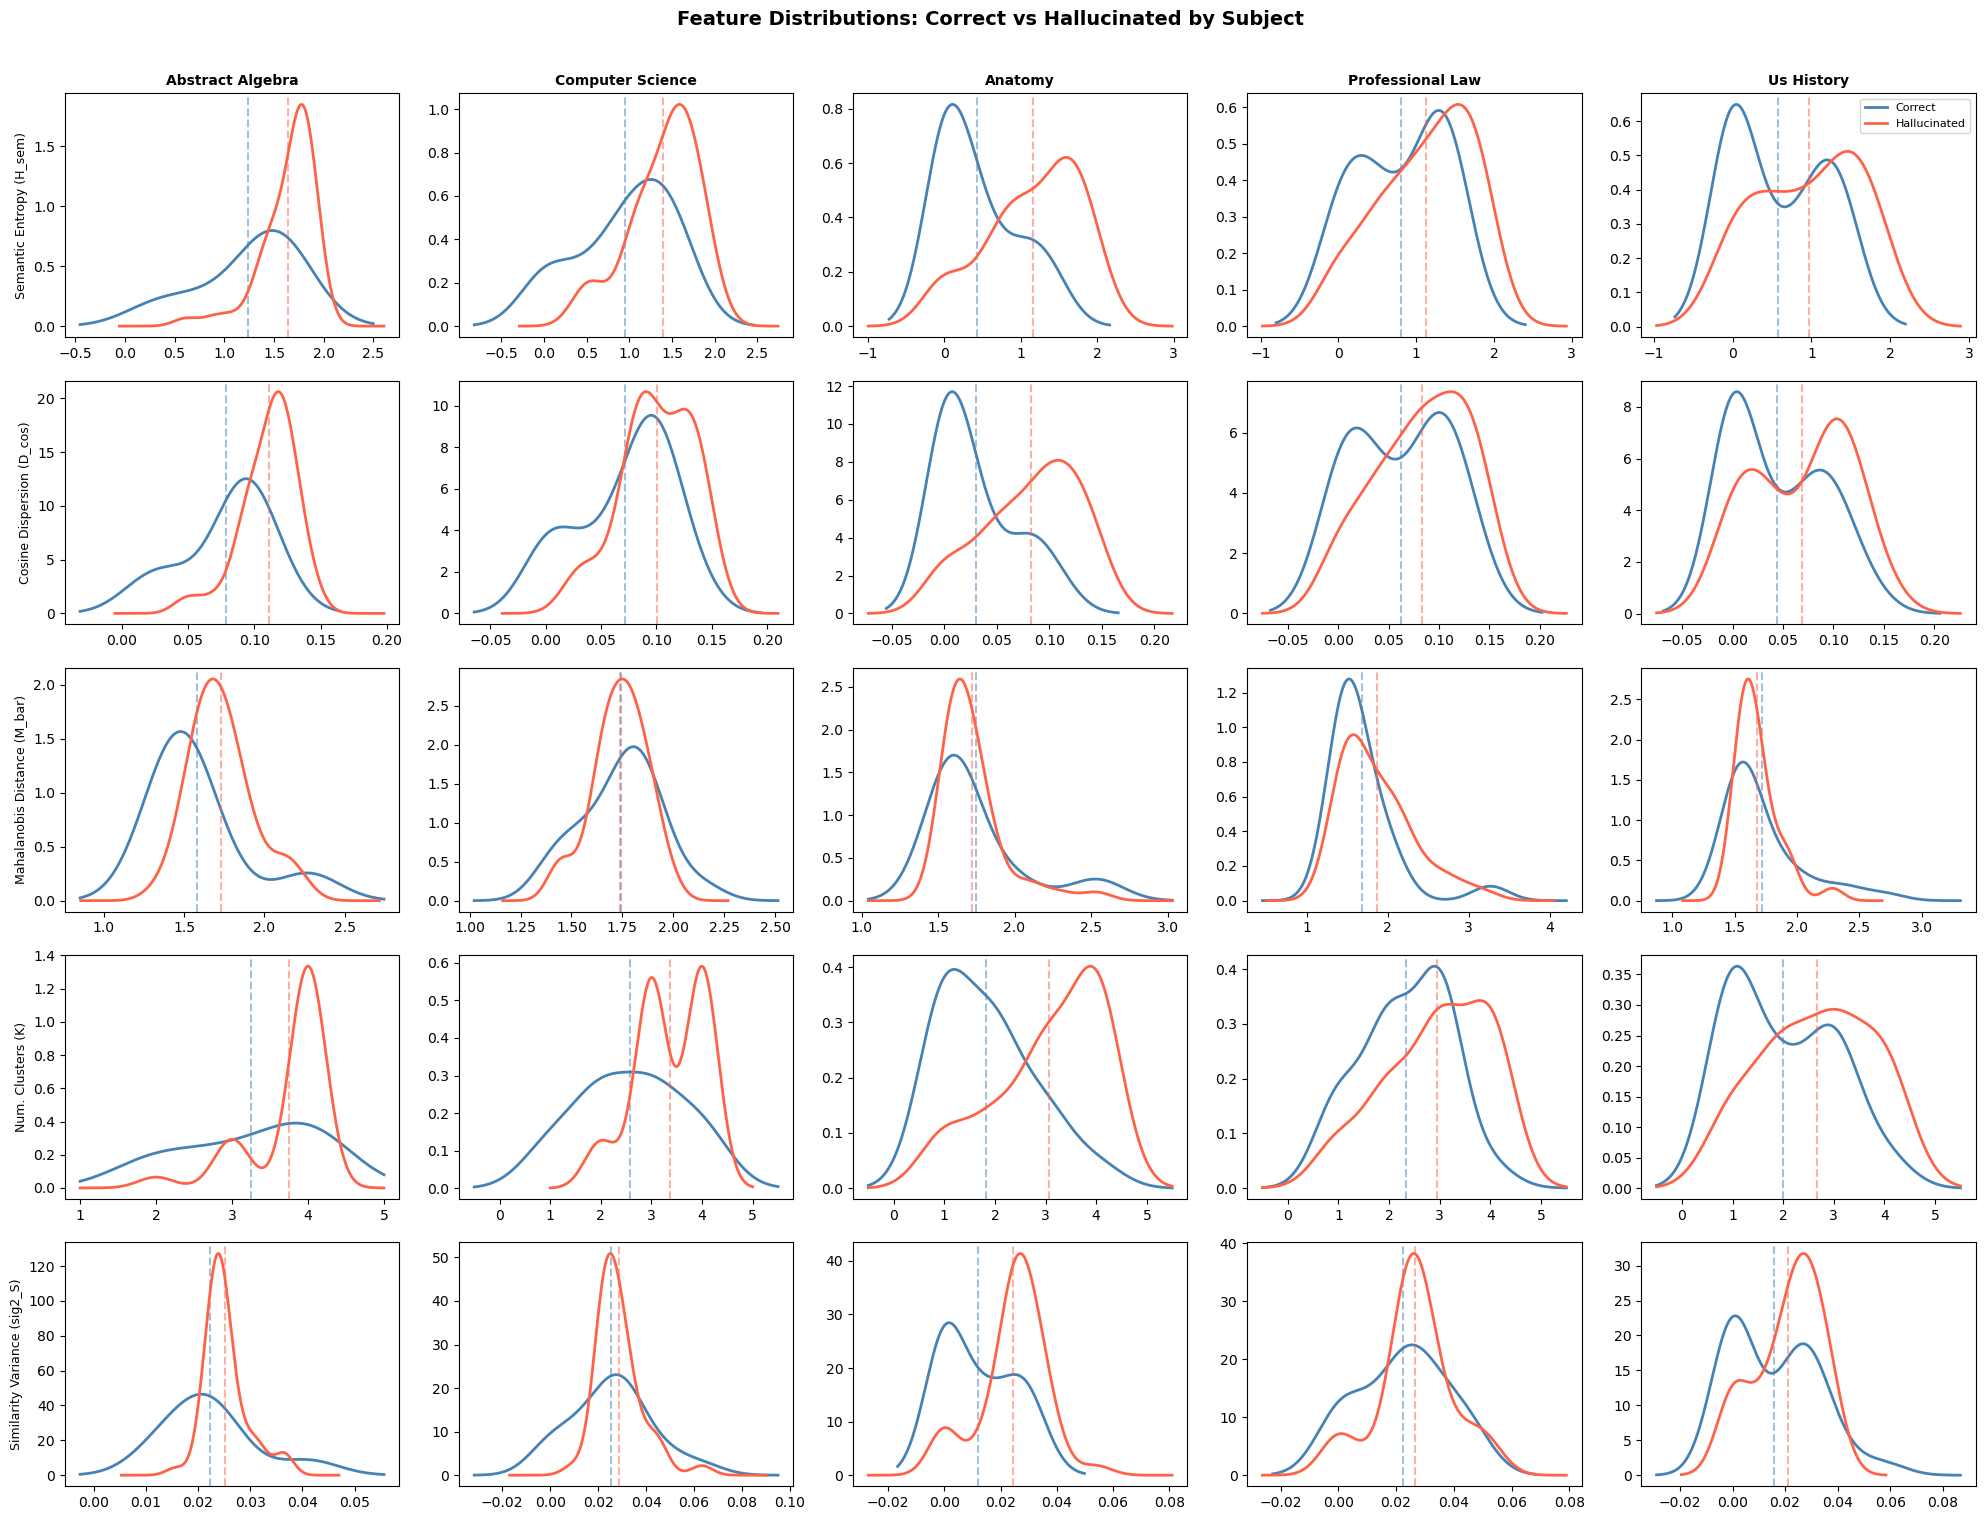

In [ ]:
FEAT_LABELS = {
    "H_sem" : "Semantic Entropy (H_sem)",
    "D_cos" : "Cosine Dispersion (D_cos)",
    "M_bar" : "Mahalanobis Distance (M_bar)",
    "K"     : "Num. Clusters (K)",
    "sig2_S": "Similarity Variance (sig2_S)",
}

subjects_ordered = summary["subject"].tolist()

fig, axes = plt.subplots(
    len(FEAT_LABELS), N_SUBJECTS,
    figsize=(4 * N_SUBJECTS, 3 * len(FEAT_LABELS)),
    sharey=False
)
fig.suptitle(
    "Feature Distributions: Correct vs Hallucinated by Subject",
    fontsize=14, fontweight="bold", y=1.01
)

for row, (feat, feat_label) in enumerate(FEAT_LABELS.items()):
    for col, subj_label in enumerate(subjects_ordered):
        ax  = axes[row][col]
        sub = df_all[df_all["subject"] == subj_label]
        for lbl, color, name in [(0,"steelblue","Correct"),(1,"tomato","Hallucinated")]:
            vals = sub[sub["label"] == lbl][feat]
            if len(vals) > 2:
                vals.plot.kde(ax=ax, color=color, label=name, linewidth=2)
                ax.axvline(vals.mean(), color=color, linestyle="--", alpha=0.5)
        if row == 0:
            ax.set_title(subj_label, fontweight="bold", fontsize=10)
        ax.set_ylabel(feat_label if col == 0 else "", fontsize=9)
        ax.set_xlabel("")
        if row == 0 and col == N_SUBJECTS - 1:
            ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

### Mean Feature Values by Subject (Heatmaps)

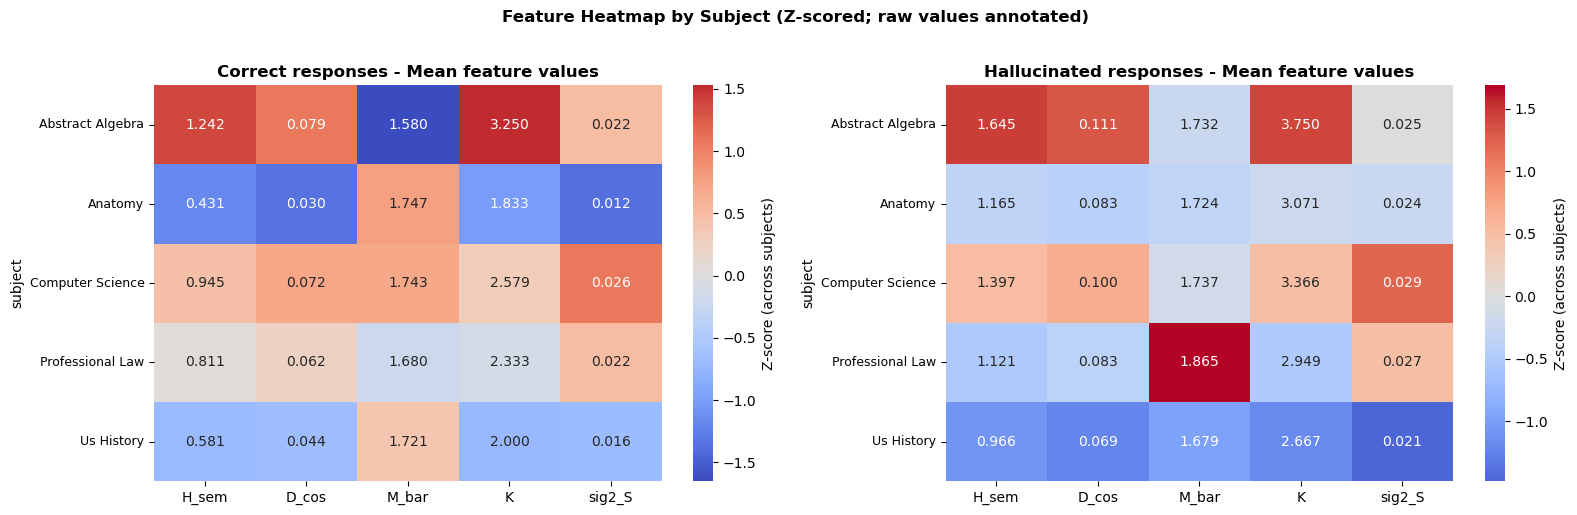

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for ax_idx, (lbl_val, split_name) in enumerate([(0, "Correct"), (1, "Hallucinated")]):
    hm_data = (
        df_all[df_all["label"] == lbl_val]
        .groupby("subject")[FEATURE_NAMES]
        .mean()
    )
    hm_norm = (hm_data - hm_data.mean()) / (hm_data.std() + 1e-9)
    sns.heatmap(
        hm_norm,
        annot=hm_data.round(3), fmt=".3f",
        cmap="coolwarm", center=0,
        xticklabels=["H_sem","D_cos","M_bar","K","sig2_S"],
        yticklabels=hm_data.index,
        ax=axes[ax_idx],
        cbar_kws={"label": "Z-score (across subjects)"},
    )
    axes[ax_idx].set_title(
        f"{split_name} responses - Mean feature values", fontweight="bold"
    )
    axes[ax_idx].tick_params(axis="y", labelsize=9)

plt.suptitle(
    "Feature Heatmap by Subject (Z-scored; raw values annotated)",
    fontweight="bold", y=1.02
)
plt.tight_layout()
plt.show()

## Statistical Tests
### KS Tests — Per Feature Per Subject

We test whether each feature's distribution **differs significantly** between correct and  
hallucinated questions, separately for every subject.  
Bonferroni correction: `alpha_adj = 0.05 / (5 features x n_subjects)`.

Bonferroni alpha = 0.00200



,Subject,Feature,KS_stat,p_value,Significant
0,Abstract Algebra,H_sem,0.567,0.0134,False
1,Abstract Algebra,D_cos,0.625,0.0043,False
2,Abstract Algebra,M_bar,0.615,0.0054,False
3,Abstract Algebra,K,0.288,0.5305,False
4,Abstract Algebra,sig2_S,0.558,0.0163,False
5,Anatomy,H_sem,0.579,0.0002,True
6,Anatomy,D_cos,0.532,0.0009,True
7,Anatomy,M_bar,0.270,0.2704,False
8,Anatomy,K,0.516,0.0014,True
9,Anatomy,sig2_S,0.508,0.0018,True


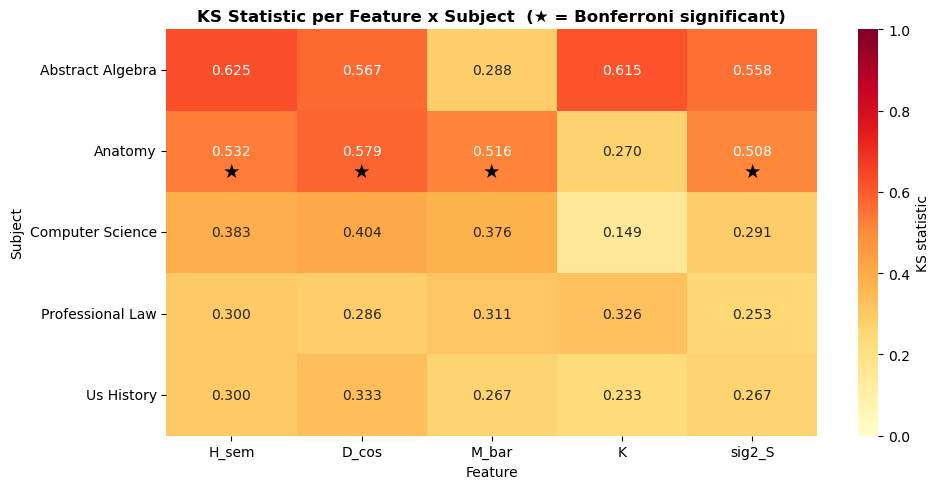

In [ ]:
alpha_bonf = 0.05 / (len(FEATURE_NAMES) * N_SUBJECTS)
print(f"Bonferroni alpha = {alpha_bonf:.5f}\n")

ks_rows = []
for subj in CONFIG["mmlu_subjects"]:
    label = SUBJECT_LABELS[subj]
    df_s  = subject_data[subj]["df"]
    for feat in FEATURE_NAMES:
        g0 = df_s[df_s["label"] == 0][feat]
        g1 = df_s[df_s["label"] == 1][feat]
        if len(g0) < 2 or len(g1) < 2:
            continue
        stat, p = ks_2samp(g0, g1)
        ks_rows.append({
            "Subject"    : label,
            "Feature"    : feat,
            "KS_stat"    : round(stat, 3),
            "p_value"    : round(p, 4),
            "Significant": p < alpha_bonf,
        })

df_ks = pd.DataFrame(ks_rows)
display(df_ks)

ks_pivot  = df_ks.pivot(index="Subject", columns="Feature", values="KS_stat").fillna(0)
sig_pivot = df_ks.pivot(index="Subject", columns="Feature", values="Significant").fillna(False)

plt.figure(figsize=(10, 5))
ax = sns.heatmap(
    ks_pivot, annot=True, fmt=".3f",
    cmap="YlOrRd", vmin=0, vmax=1,
    xticklabels=["H_sem","D_cos","M_bar","K","sig2_S"],
    cbar_kws={"label": "KS statistic"}
)
for i, subject in enumerate(ks_pivot.index):
    for j, feat in enumerate(ks_pivot.columns):
        if sig_pivot.loc[subject, feat]:
            ax.text(j+0.5, i+0.75, "★", ha="center", va="center",
                    color="black", fontsize=14)

plt.title("KS Statistic per Feature x Subject  (★ = Bonferroni significant)",
          fontweight="bold")
plt.tight_layout()
plt.show()

## Classification — Per-Subject AUC Comparison

We train XGBoost + Random Forest + Logistic Regression on each subject separately  
using 5-fold stratified CV, then compare AUC-ROC across subjects.

5-fold CV AUC-ROC per subject x classifier:



Classifier,Logistic Regression,Random Forest,XGBoost
Subject,,,
Abstract Algebra,0.774,0.740,0.730
Anatomy,0.793,0.689,0.663
Computer Science,0.728,0.761,0.753
Professional Law,0.655,0.490,0.503
Us History,0.631,0.458,0.419


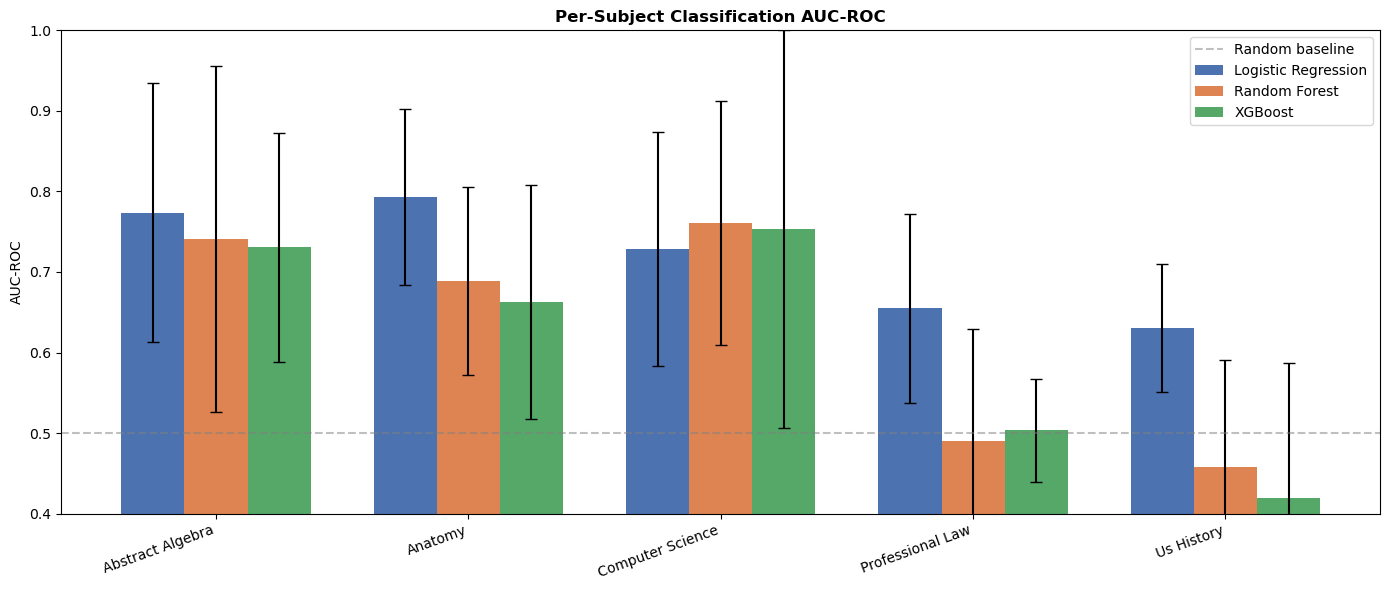

In [ ]:
classifiers = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000, random_state=CONFIG["random_seed"]
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, random_state=CONFIG["random_seed"]
    ),
    "XGBoost": xgb.XGBClassifier(
        n_estimators=200, eval_metric="logloss",
        random_state=CONFIG["random_seed"], verbosity=0
    ),
}

cv       = StratifiedKFold(n_splits=5, shuffle=True, random_state=CONFIG["random_seed"])
scaler   = StandardScaler()
clf_rows = []

for subj in CONFIG["mmlu_subjects"]:
    label    = SUBJECT_LABELS[subj]
    X_s, y_s = subject_data[subj]["X"], subject_data[subj]["y"]
    if len(np.unique(y_s)) < 2:
        print(f"  Skipping {label}: only one class present.")
        continue
    X_sc = scaler.fit_transform(X_s)
    for clf_name, clf in classifiers.items():
        scores = cross_val_score(clf, X_sc, y_s, cv=cv, scoring="roc_auc")
        clf_rows.append({
            "Subject"   : label,
            "Classifier": clf_name,
            "AUC Mean"  : scores.mean(),
            "AUC Std"   : scores.std(),
        })

df_clf = pd.DataFrame(clf_rows)
pivot  = df_clf.pivot_table(
    index="Subject", columns="Classifier", values="AUC Mean"
).round(3)
print("5-fold CV AUC-ROC per subject x classifier:\n")
display(pivot)

subjects_list = list(pivot.index)
x_pos      = np.arange(len(subjects_list))
width      = 0.25
clf_names  = list(classifiers.keys())
colors_clf = ["#4C72B0", "#DD8452", "#55A868"]

fig, ax = plt.subplots(figsize=(14, 6))
for i, (clf_name, color) in enumerate(zip(clf_names, colors_clf)):
    sub_df = df_clf[df_clf["Classifier"] == clf_name].set_index("Subject")
    aucs   = sub_df.reindex(subjects_list)["AUC Mean"].fillna(0)
    stds   = sub_df.reindex(subjects_list)["AUC Std"].fillna(0)
    ax.bar(x_pos + i*width, aucs, width, label=clf_name,
           color=color, yerr=stds, capsize=4)

ax.set_xticks(x_pos + width)
ax.set_xticklabels(subjects_list, rotation=20, ha="right")
ax.set_ylabel("AUC-ROC")
ax.set_ylim(0.4, 1.0)
ax.axhline(0.5, color="gray", linestyle="--", alpha=0.5, label="Random baseline")
ax.set_title("Per-Subject Classification AUC-ROC", fontweight="bold")
ax.legend()
plt.tight_layout()
plt.show()

## Ablation Study — Feature Subsets vs Subjects

Comparing **entropy-only**, **geometry-only**, and **all features** across subjects  
using XGBoost.

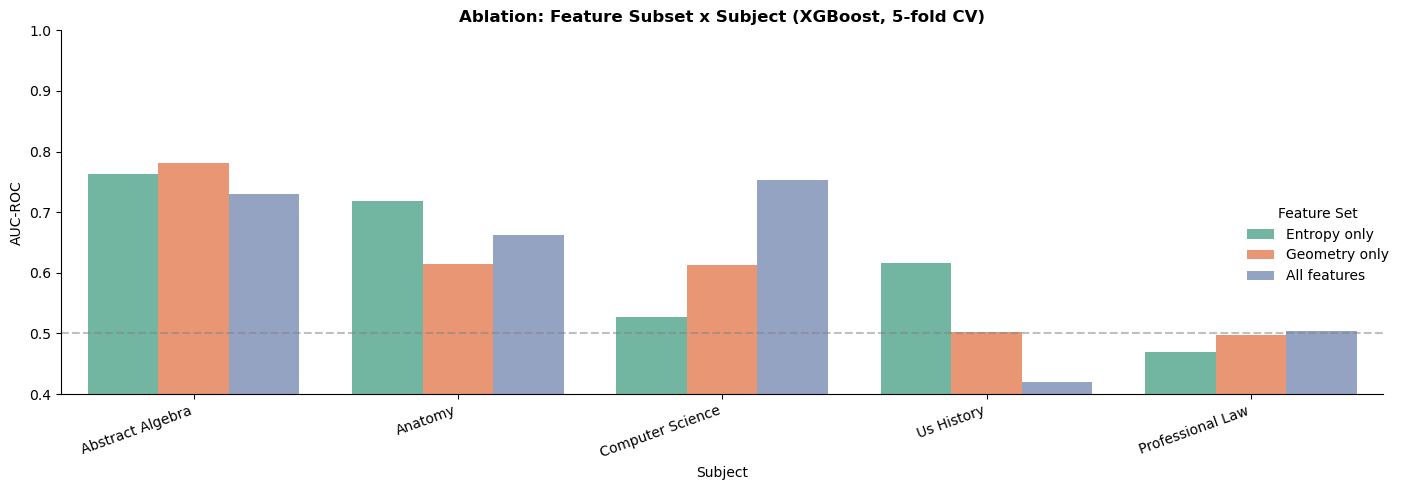

Feature Set,All features,Entropy only,Geometry only
Subject,,,
Abstract Algebra,0.730,0.763,0.780
Anatomy,0.663,0.719,0.614
Computer Science,0.753,0.528,0.613
Professional Law,0.503,0.469,0.498
Us History,0.419,0.617,0.503


In [ ]:
feature_subsets = {
    "Entropy only" : [0],
    "Geometry only": [1, 2],
    "All features" : [0, 1, 2, 3, 4],
}

xgb_clf  = xgb.XGBClassifier(
    n_estimators=200, eval_metric="logloss",
    random_state=CONFIG["random_seed"], verbosity=0
)
abl_rows = []

for subj in CONFIG["mmlu_subjects"]:
    label    = SUBJECT_LABELS[subj]
    X_s, y_s = subject_data[subj]["X"], subject_data[subj]["y"]
    if len(np.unique(y_s)) < 2:
        continue
    X_sc = scaler.fit_transform(X_s)
    for subset_name, feat_idx in feature_subsets.items():
        X_sub  = X_sc[:, feat_idx]
        scores = cross_val_score(xgb_clf, X_sub, y_s, cv=cv, scoring="roc_auc")
        abl_rows.append({
            "Subject"    : label,
            "Feature Set": subset_name,
            "AUC"        : scores.mean(),
            "Std"        : scores.std(),
        })

df_abl = pd.DataFrame(abl_rows)

g = sns.catplot(
    data=df_abl, kind="bar",
    x="Subject", y="AUC", hue="Feature Set",
    palette="Set2", height=5, aspect=2.5,
    capsize=0.05, errwidth=1.5
)
g.ax.axhline(0.5, color="gray", linestyle="--", alpha=0.5)
g.ax.set_ylim(0.4, 1.0)
g.ax.set_title("Ablation: Feature Subset x Subject (XGBoost, 5-fold CV)",
               fontweight="bold")
g.ax.set_ylabel("AUC-ROC")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

display(
    df_abl.pivot_table(index="Subject", columns="Feature Set", values="AUC").round(3)
)

## Per-Subject Feature Importance (XGBoost GAIN)

We train one XGBoost model per subject and compare which features drive  
hallucination detection most strongly in each domain.

Normalized GAIN importance per subject:


,H_sem,D_cos,M_bar,K,sig2_S
Abstract Algebra,0.216,0.189,0.326,0.087,0.182
Anatomy,0.372,0.187,0.108,0.138,0.195
Computer Science,0.223,0.226,0.109,0.243,0.199
Us History,0.368,0.157,0.184,0.086,0.206
Professional Law,0.161,0.204,0.158,0.345,0.132


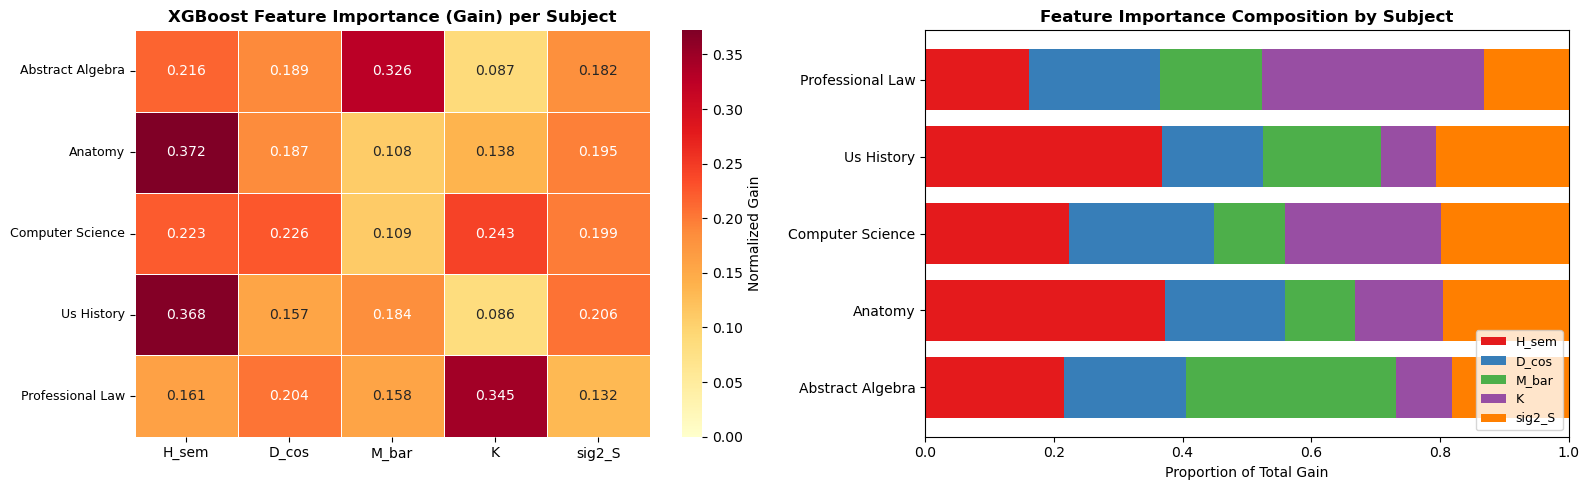

In [ ]:
importance_data = {}
feat_colors     = ["#e41a1c","#377eb8","#4daf4a","#984ea3","#ff7f00"]

xgb_best = xgb.XGBClassifier(
    n_estimators=300, max_depth=3, learning_rate=0.08,
    subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
    eval_metric="logloss", random_state=CONFIG["random_seed"], verbosity=0
)

for subj in CONFIG["mmlu_subjects"]:
    label    = SUBJECT_LABELS[subj]
    X_s, y_s = subject_data[subj]["X"], subject_data[subj]["y"]
    if len(np.unique(y_s)) < 2:
        importance_data[label] = np.zeros(len(FEATURE_NAMES))
        continue
    X_sc = scaler.fit_transform(X_s)
    xgb_best.fit(X_sc, y_s)
    booster   = xgb_best.get_booster()
    gain_dict = booster.get_score(importance_type="gain")
    gains = np.array(
        [gain_dict.get(f"f{i}", 0.0) for i in range(len(FEATURE_NAMES))],
        dtype=float
    )
    total = gains.sum()
    importance_data[label] = gains / total if total > 0 else gains

df_imp = pd.DataFrame(
    importance_data,
    index=["H_sem","D_cos","M_bar","K","sig2_S"]
).T

print("Normalized GAIN importance per subject:")
display(df_imp.round(3))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.heatmap(
    df_imp, annot=True, fmt=".3f",
    cmap="YlOrRd", vmin=0, vmax=df_imp.values.max(),
    xticklabels=["H_sem","D_cos","M_bar","K","sig2_S"],
    ax=axes[0],
    cbar_kws={"label": "Normalized Gain"},
    linewidths=0.5, linecolor="white"
)
axes[0].set_title("XGBoost Feature Importance (Gain) per Subject", fontweight="bold")
axes[0].tick_params(axis="y", labelsize=9)

bottoms = np.zeros(len(df_imp))
for feat, color in zip(["H_sem","D_cos","M_bar","K","sig2_S"], feat_colors):
    vals = df_imp[feat].values
    axes[1].barh(df_imp.index, vals, left=bottoms, color=color, label=feat)
    bottoms += vals

axes[1].set_xlabel("Proportion of Total Gain")
axes[1].set_title("Feature Importance Composition by Subject", fontweight="bold")
axes[1].legend(loc="lower right", fontsize=9)
axes[1].set_xlim(0, 1)

plt.tight_layout()
plt.show()

## Per-Subject SHAP Beeswarm Plots

One SHAP plot per subject — visualising which direction each feature pushes  
the hallucination prediction.

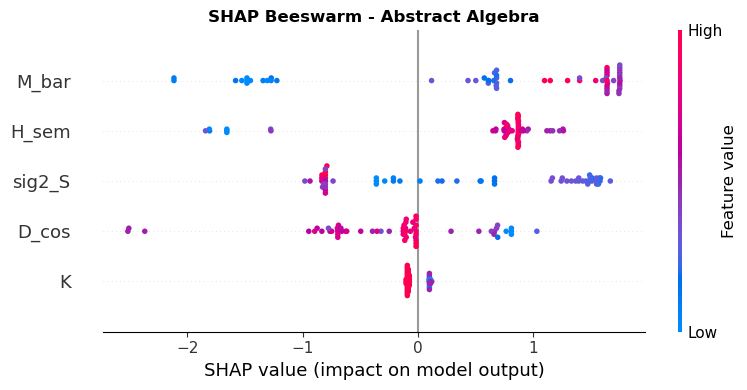

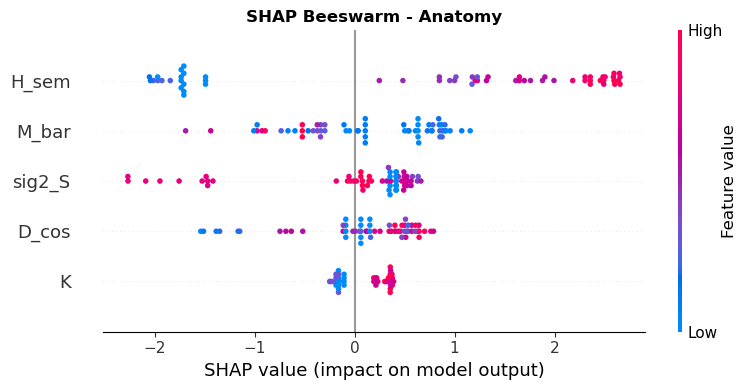

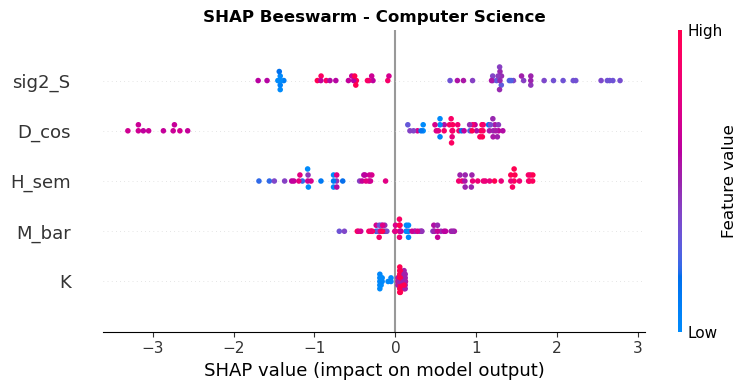

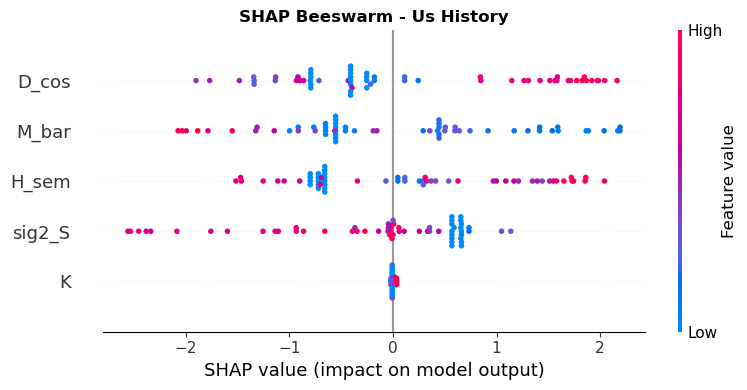

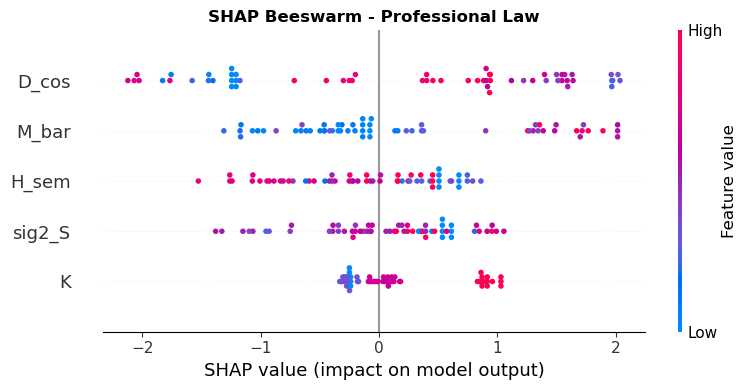

In [ ]:
feat_display = ["H_sem","D_cos","M_bar","K","sig2_S"]

for subj in CONFIG["mmlu_subjects"]:
    label    = SUBJECT_LABELS[subj]
    X_s, y_s = subject_data[subj]["X"], subject_data[subj]["y"]
    if len(np.unique(y_s)) < 2:
        print(f"Skipping SHAP for {label} (single class).")
        continue
    X_sc = scaler.fit_transform(X_s)

    xgb_shap = xgb.XGBClassifier(
        n_estimators=300, max_depth=3, learning_rate=0.08,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        eval_metric="logloss", random_state=CONFIG["random_seed"], verbosity=0
    )
    xgb_shap.fit(X_sc, y_s)

    explainer   = shap.TreeExplainer(xgb_shap)
    shap_values = explainer.shap_values(X_sc)
    sv = shap_values[1] if isinstance(shap_values, list) else shap_values

    plt.figure(figsize=(8, 4))
    shap.summary_plot(sv, X_sc, feature_names=feat_display, show=False, plot_size=None)
    plt.title(f"SHAP Beeswarm - {label}", fontweight="bold")
    plt.tight_layout()
    plt.show()

## Cross-Subject Feature Ranking Comparison

We rank the 5 features by GAIN importance for each subject and show how  
the rankings shift across domains.

Feature rank by subject (1 = most important):


,H_sem,D_cos,M_bar,K,sig2_S
Abstract Algebra,2,3,1,5,4
Anatomy,1,3,5,4,2
Computer Science,3,2,5,1,4
Us History,1,4,3,5,2
Professional Law,3,2,4,1,5


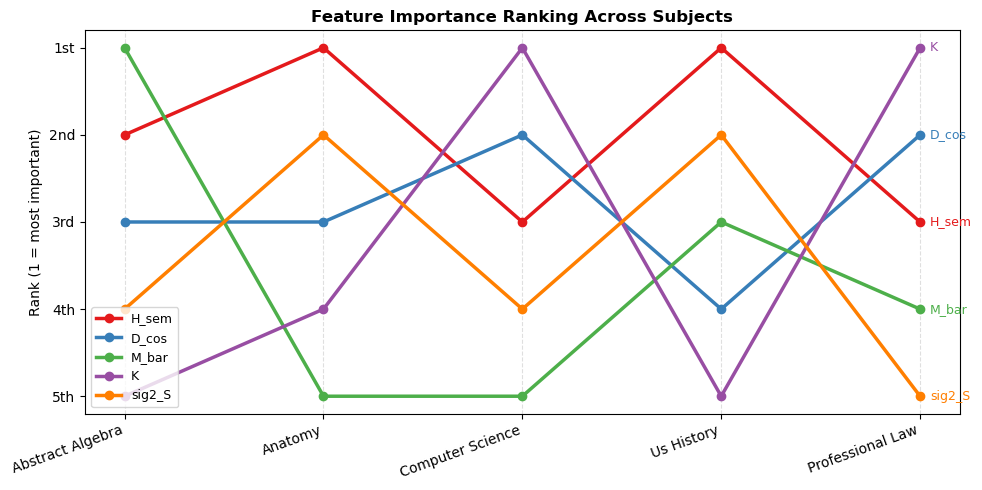

In [ ]:
df_rank = df_imp.rank(axis=1, ascending=False).astype(int)
print("Feature rank by subject (1 = most important):")
display(df_rank)

feat_colors_map = dict(zip(["H_sem","D_cos","M_bar","K","sig2_S"], feat_colors))
x_ticks = list(df_rank.index)
x_pos   = np.arange(len(x_ticks))

fig, ax = plt.subplots(figsize=(10, 5))
for feat in ["H_sem","D_cos","M_bar","K","sig2_S"]:
    ranks = df_rank[feat].values
    ax.plot(x_pos, ranks, marker="o", linewidth=2.5,
            label=feat, color=feat_colors_map[feat])
    ax.text(x_pos[-1]+0.05, ranks[-1], feat, va="center",
            color=feat_colors_map[feat], fontsize=9)

ax.set_xticks(x_pos)
ax.set_xticklabels(x_ticks, rotation=20, ha="right")
ax.set_yticks([1,2,3,4,5])
ax.set_yticklabels(["1st","2nd","3rd","4th","5th"])
ax.invert_yaxis()
ax.set_ylabel("Rank (1 = most important)")
ax.set_title("Feature Importance Ranking Across Subjects", fontweight="bold")
ax.grid(axis="x", linestyle="--", alpha=0.4)
ax.legend(loc="lower left", fontsize=9)
plt.tight_layout()
plt.show()

## Bootstrap AUC Confidence Intervals — All Subjects

500-iteration bootstrap using Random Forest, fitted per subject.

  Abstract Algebra           AUC = 0.686  95% CI [0.277, 1.000]
  Anatomy                    AUC = 0.677  95% CI [0.444, 0.862]
  Computer Science           AUC = 0.695  95% CI [0.483, 0.873]
  Us History                 AUC = 0.502  95% CI [0.317, 0.688]
  Professional Law           AUC = 0.552  95% CI [0.335, 0.770]


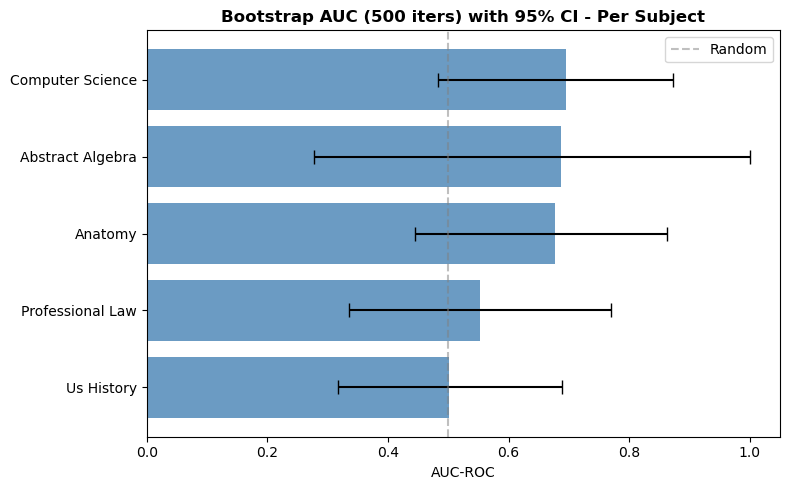

In [ ]:
boot_rows = []
rng_boot  = np.random.default_rng(CONFIG["random_seed"])

for subj in CONFIG["mmlu_subjects"]:
    label    = SUBJECT_LABELS[subj]
    X_s, y_s = subject_data[subj]["X"], subject_data[subj]["y"]
    if len(np.unique(y_s)) < 2:
        continue
    X_sc = scaler.fit_transform(X_s)

    auc_boot = []
    for _ in range(500):
        idx = rng_boot.choice(len(y_s), len(y_s), replace=True)
        oob = np.setdiff1d(np.arange(len(y_s)), idx)
        if len(np.unique(y_s[oob])) < 2:
            continue
        clf_b = RandomForestClassifier(n_estimators=50, random_state=0)
        clf_b.fit(X_sc[idx], y_s[idx])
        proba = clf_b.predict_proba(X_sc[oob])[:, 1]
        auc_boot.append(roc_auc_score(y_s[oob], proba))

    if len(auc_boot) == 0:
        continue
    ci_lo, ci_hi = np.percentile(auc_boot, [2.5, 97.5])
    boot_rows.append({
        "Subject" : label,
        "AUC Mean": np.mean(auc_boot),
        "CI Low"  : ci_lo,
        "CI High" : ci_hi,
    })
    print(f"  {label:25s}  AUC = {np.mean(auc_boot):.3f}  "
          f"95% CI [{ci_lo:.3f}, {ci_hi:.3f}]")

df_boot = pd.DataFrame(boot_rows).sort_values("AUC Mean", ascending=True)

fig, ax = plt.subplots(figsize=(8, 5))
y_pos = np.arange(len(df_boot))
ax.barh(
    y_pos, df_boot["AUC Mean"],
    xerr=[df_boot["AUC Mean"] - df_boot["CI Low"],
          df_boot["CI High"]  - df_boot["AUC Mean"]],
    capsize=5, color="steelblue", alpha=0.8
)
ax.set_yticks(y_pos)
ax.set_yticklabels(df_boot["Subject"])
ax.axvline(0.5, color="gray", linestyle="--", alpha=0.5, label="Random")
ax.set_xlabel("AUC-ROC")
ax.set_title("Bootstrap AUC (500 iters) with 95% CI - Per Subject", fontweight="bold")
ax.legend()
plt.tight_layout()
plt.show()

## ROC Curves — Best Model Per Subject

One ROC curve per subject, trained on all data for visual inspection.

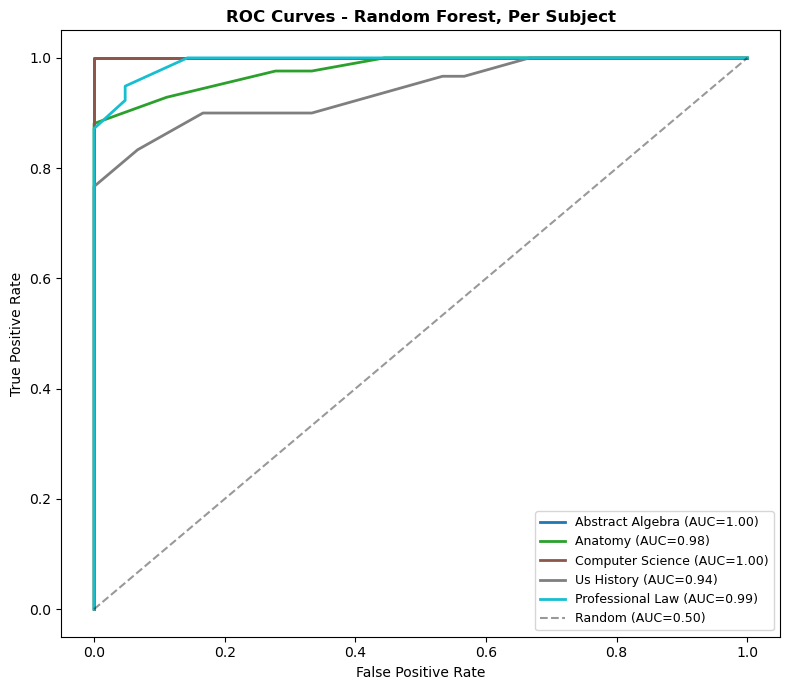

In [ ]:
fig, ax = plt.subplots(figsize=(8, 7))
roc_colors = plt.cm.tab10(np.linspace(0, 1, N_SUBJECTS))

for color, subj in zip(roc_colors, CONFIG["mmlu_subjects"]):
    label    = SUBJECT_LABELS[subj]
    X_s, y_s = subject_data[subj]["X"], subject_data[subj]["y"]
    if len(np.unique(y_s)) < 2:
        continue
    X_sc = scaler.fit_transform(X_s)
    rf   = RandomForestClassifier(n_estimators=200, random_state=CONFIG["random_seed"])
    rf.fit(X_sc, y_s)
    proba       = rf.predict_proba(X_sc)[:, 1]
    fpr, tpr, _ = roc_curve(y_s, proba)
    auc         = roc_auc_score(y_s, proba)
    ax.plot(fpr, tpr, color=color, lw=2, label=f"{label} (AUC={auc:.2f})")

ax.plot([0,1],[0,1],"k--", alpha=0.4, label="Random (AUC=0.50)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves - Random Forest, Per Subject", fontweight="bold")
ax.legend(loc="lower right", fontsize=9)
plt.tight_layout()
plt.show()

## Summary

In [ ]:
print("=" * 65)
print("MULTI-SUBJECT HALLUCINATION DETECTION - SUMMARY")
print("=" * 65)
print(f"  Subjects  : {list(SUBJECT_LABELS.values())}")
print(f"  Questions : {CONFIG['n_questions']} per subject")
print(f"  Samples/Q : {CONFIG['n_samples']}")
print(f"  Total rows: {len(df_all)}")
print()
print("  Hallucination rates:")
for row in summary.itertuples():
    print(f"    {row.subject:25s}: {row.hall_rate_mean*100:.1f}% "
          f"(+/-{row.hall_rate_std*100:.1f}%)")
print()
print("  Key findings (from feature importance):")
for subj_label, row in df_imp.iterrows():
    top_feat = row.idxmax()
    top_val  = row.max()
    print(f"    {subj_label:25s}: top feature = {top_feat:10s} (gain={top_val:.3f})")
print()
if len(df_boot) > 0:
    best  = df_boot.loc[df_boot["AUC Mean"].idxmax()]
    worst = df_boot.loc[df_boot["AUC Mean"].idxmin()]
    print(f"  Best  detectability: {best['Subject']}"
          f"  AUC={best['AUC Mean']:.3f} [{best['CI Low']:.3f}, {best['CI High']:.3f}]")
    print(f"  Worst detectability: {worst['Subject']}"
          f"  AUC={worst['AUC Mean']:.3f} [{worst['CI Low']:.3f}, {worst['CI High']:.3f}]")
print()
print("  Tips to improve results:")
print("    Increase n_questions to 200+ per subject for better statistics")
print("    Swap flan-t5-base -> flan-t5-large for stronger generation")
print("    Add more subjects to CONFIG['mmlu_subjects']")
print("=" * 65)

MULTI-SUBJECT HALLUCINATION DETECTION - SUMMARY
  Subjects  : ['Abstract Algebra', 'Anatomy', 'Computer Science', 'Us History', 'Professional Law']
  Questions : 60 per subject
  Samples/Q : 20
  Total rows: 300

  Hallucination rates:
    Abstract Algebra         : 72.6% (+/-19.3%)
    Computer Science         : 68.8% (+/-30.6%)
    Anatomy                  : 65.9% (+/-38.0%)
    Professional Law         : 64.0% (+/-33.2%)
    Us History               : 52.3% (+/-39.0%)

  Key findings (from feature importance):
    Abstract Algebra         : top feature = M_bar      (gain=0.326)
    Anatomy                  : top feature = H_sem      (gain=0.372)
    Computer Science         : top feature = K          (gain=0.243)
    Us History               : top feature = H_sem      (gain=0.368)
    Professional Law         : top feature = K          (gain=0.345)

  Best  detectability: Computer Science  AUC=0.695 [0.483, 0.873]
  Worst detectability: Us History  AUC=0.502 [0.317, 0.688]

  Tips t